In [2]:
!pip install xgboost
!pip install plotnine

Keyring is skipped due to an exception: 'keyring.backends'
Keyring is skipped due to an exception: 'keyring.backends'


In [3]:
import sys
import os
import glob
import numpy as np
import pandas as pd
import plotnine
from plotnine import *

# Hardcode so we can use in any notebook
module_path = "/root/HAIP/services"
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# from sharepoint_transfer.src import main as sharepoint_transfer_svc
from data_consolidation.src import main as data_consolidation_svc
from feature_engineering.src import main as feature_engineering_svc
from model_selection.src import main as model_selection_svc
from outcome_analysis.src import main as outcome_analysis_svc
from model_training.src import main as model_training_svc
from final_fitting.src import main as final_fitting_svc
from ensemble_model.src import main as ensemble_model_svc

from model_dataset.src.main import load_dataframe
from artificial_anomaly_tests.aa_tests import artificial_anomaly_test_xgb
from model_training import xgbr_test
from artificial_anomaly_tests import aa_tests

## Set Measure Specific Settings

These will augment and override settings in "/root/HAIP/notebooks/services/config.json"

In [5]:
SKIP_TUNING = True
SKIP_RMSE_TEST = False

settings = {
    # Measure specific options
    "MEASURE_SPECIFIC_FILENAME": "OP-23.csv",
    "FULL_MEASURE_S3_PREFIX": "OP-23",
    "filter_measure": "OP_23", # make sure this is _ not -
    
    "run_save_path": "model_runs",
    "shift_range": range(15, 30), # for isolation_forest
    
    # Feature Engineering options
    "backfill_prov_mean": False, # set to false to not backfill prov mean
    "backfill_lag": False, # set to false to not backfill lag
    "lag_to_add": 2, # add lag1/lag2
}

settings['save_modeling_dataset_path'] = f"/root/HAIP/data/{settings.get('MEASURE_SPECIFIC_FILENAME')}"
settings['model_dataset_path'] = settings['save_modeling_dataset_path']

In [6]:
op23 = pd.read_csv(settings['save_modeling_dataset_path'])
print(settings['save_modeling_dataset_path'])

op23['score'].value_counts()

/root/HAIP/data/OP-23.csv


100.0    1741
82.0     1223
83.0     1188
92.0     1139
73.0     1095
         ... 
49.0        8
34.0        7
3.0         4
2.0         4
4.0         3
Name: score, Length: 98, dtype: int64

## Move Sharepoint files to S3

This is not possible in SageMaker Studio because we are trying to figure out Client ID/Secret for the Sharepoint REST API. For now, run the service locally using your own Office365 username/password

## Data Consolidation

Make sure the measure `settings` are changed.


Call `data_consolidation_main.main(settings)`


This will download the full-measure-data in S3, load it into a single data frame, normalize the columns, filter to only include `filter_measure` and then upload the result to S3.


Result csv and metadata are uploaded to https://s3.console.aws.amazon.com/s3/buckets/haip-measure-specific-data?region=us-east-1&tab=objects

In [7]:
# data_consolidation_svc.main(settings)

## Feature Engineering

Call `feature_engineering_main.main(settings)`

This will download the consolidated measure-specific-data in S3, normalize the columns, and add the new features, then upload the result to S3.
Results should also be saved locally automatically, but that is not yet implemented. For now download from the link below and upload the file to SageMaker Studio.


Result csv and metadata are uploaded to https://s3.console.aws.amazon.com/s3/buckets/haip-modeling-dataset?region=us-east-1&tab=objects

In [8]:
# feature_engineering_svc.main(settings)

## XGBoost Regression

In [9]:
## Shift Ranges

In [10]:
sr_settings = {
    # Doesn't matter they all import modeling df the same
    # just need one for it to work
    "model_type": "XGBRegression",
}

settings = {**settings, **sr_settings}

In [11]:
sr_tuner = model_training_svc.get_model_trainer(settings)

dist_results_scatter = aa_tests.get_bootstrap_sample(
    model_data = sr_tuner.modeling_df,
    # model_data = sr_tuner.modeling_df.loc[~((sr_tuner.modeling_df['year'] == 2016) & (sr_tuner.modeling_df['quarter'] == 1))],
    # model_data = sr_tuner.modeling_df.loc[((sr_tuner.modeling_df['year'] == 2016) & (sr_tuner.modeling_df['quarter'] == 1))].drop_duplicates(subset=['provider_id'], keep='last'),
    scatter = True,
    shift_n = 1000,
    shift_range = range(20,60,5),
    threshold_high=100,
    rng=12
)

dist_results_scatter = dist_results_scatter[['provider_id', 'score','mock_score', 'shift']]
dist_results_scatter

,provider_id,score,mock_score,shift
15382,330153,75.0,70.859087,20
6295,160117,89.0,70.484156,20
28098,490098,93.0,90.951798,20
21328,390093,17.0,7.990566,20
8073,190274,60.0,72.280049,20
...,...,...,...,...
3882,140062,89.0,94.924679,55
4031,140101,88.0,54.360174,55
14176,310003,78.0,73.440990,55
22845,40118,56.0,13.800370,55


In [12]:
melted_dist_scatter = pd.melt(dist_results_scatter, id_vars = ['provider_id','shift'])
melted_dist_scatter.loc[melted_dist_scatter['variable'] == 'score', 'variable'] = "Original Bootstrap Sample"
melted_dist_scatter.loc[melted_dist_scatter['variable'] == 'mock_score', 'variable'] = "Artificial Anomaly"
melted_dist_scatter = melted_dist_scatter.rename(columns = {'variable': 'group','value': 'score' })
melted_dist_scatter['score'].value_counts()

100.000000    436
92.000000     269
83.000000     265
82.000000     265
75.000000     256
             ... 
90.461719       1
70.527651       1
51.485640       1
65.560108       1
74.297346       1
Name: score, Length: 8096, dtype: int64

In [13]:
sr_tuner.modeling_df['score'].value_counts()

100.0    1629
83.0     1113
82.0     1067
92.0     1055
67.0      996
         ... 
49.0        8
34.0        7
2.0         4
3.0         3
4.0         3
Name: score, Length: 98, dtype: int64

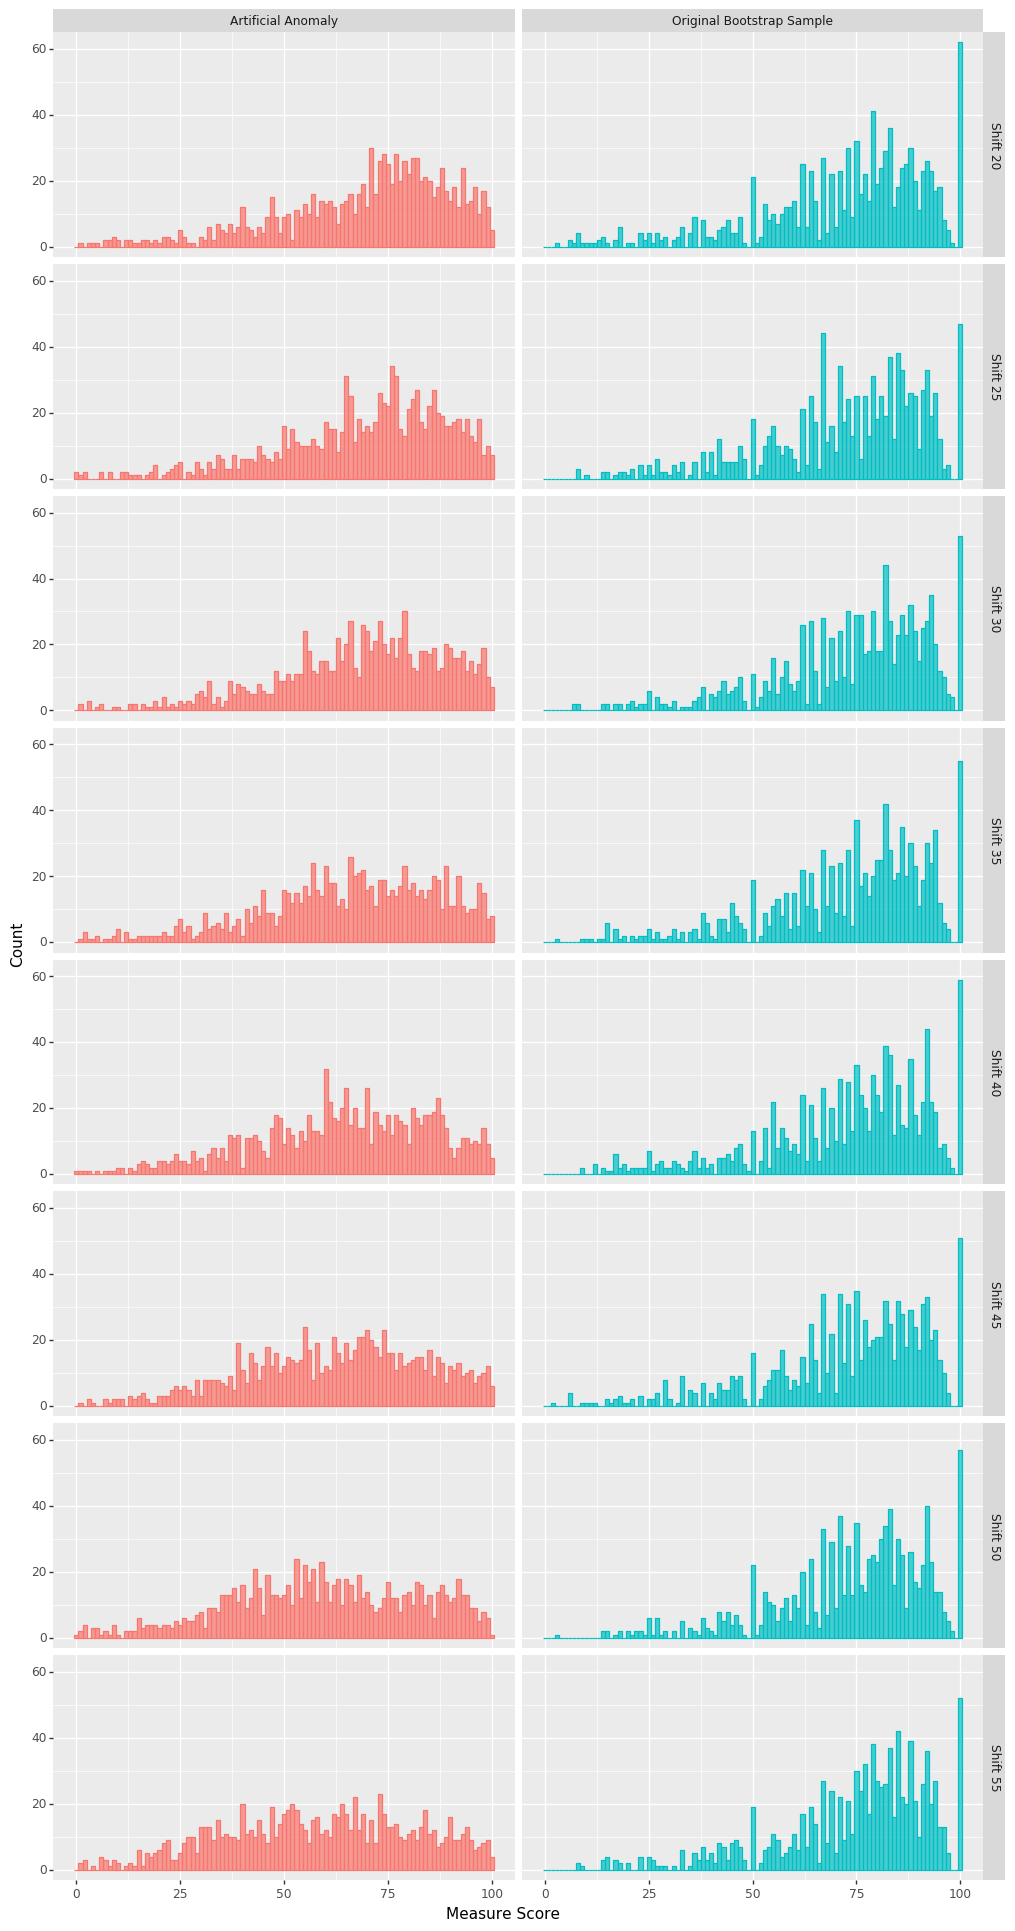

<ggplot: (8746922573037)>

In [14]:
plotnine.options.figure_size = (12,24)
graph_df = melted_dist_scatter.copy()
graph_df['shift'] = ('Shift ' + graph_df['shift'].astype(str).str.zfill(2))
(ggplot(graph_df, 
        aes(x = 'score',
            color = 'group',
            fill = 'group')
       )
 + labs(x = 'Measure Score', 
        y = 'Count',
        color = 'Group',
        fill = 'Group')
 + geom_histogram(binwidth = 1, alpha = 0.7) 
 + scale_color_manual(values = ["#F8766D", "#00BFC4"], 
                      guide = False)
 + scale_fill_manual(values = ["#F8766D", "#00BFC4"],
                     guide = False)
 + facet_grid('shift ~ group ')
 
)

### Feature Importance

In [15]:
xgbr_feature_importance_settings = {
    "model_type": "XGBRegression", 
    "xgbr_parameters": {
        'eta': [[0.05, 0.1, 0.2, 0.3]],
        'gamma': [range(0, 3)],  # [range(0, 2)]
        'max_depth': [range(5, 10)],  # [range(5, 9)]
        'min_child_weight': [range(3, 10)],  # [range(3, 9)]
        'subsample': [[1]],
        'alpha': [[0, 1, 2]]
    },
    "drop_cols": ['provider_id', 'lag_diff', 'prov_mean_diff'],
}

settings = {**settings, **xgbr_feature_importance_settings}

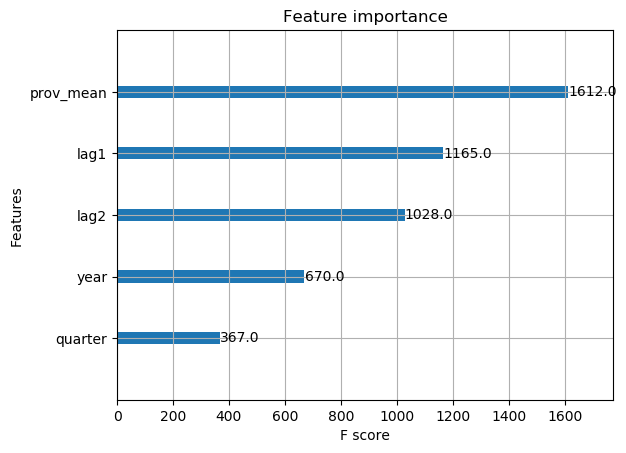

In [16]:
xgbr_tuner = model_training_svc.get_model_trainer(settings)
xgbr_tuner.plot_feature_importance()

In [17]:
xgbr_drop_cols = ['provider_id', 'lag2', 'lag_diff', 'prov_mean_diff', 'year', 'quarter']
xgbr_feature_importance_settings = {
    "model_type": "XGBRegression",
    "drop_cols": xgbr_drop_cols,
}

settings = {**settings, **xgbr_feature_importance_settings}

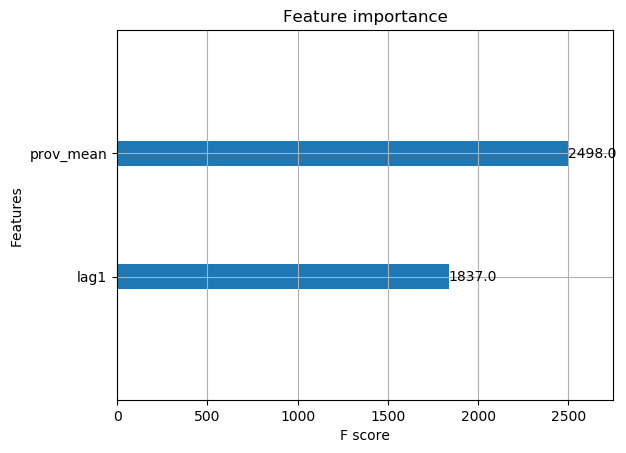

In [18]:
xgbr_tuner = model_training_svc.get_model_trainer(settings)
xgbr_tuner.plot_feature_importance()

### Tuning

In [19]:
candidate = None
# if not SKIP_TUNING:
#     candidate = xgbr_tuner.tune()

In [20]:
candidate

### Model Selection

Make sure `model_run_data_path` is set in settings to the tuning result path.
Make sure `model_type` is set in settings to `XGBRegression`, `Isolation Forest`, or `Ensemble`

Call `model_selector = model_selection_main.get_model_selector(settings)` to get the appropriate selector.
Then call `model_selector.get_top_models()` to get the top models

To get the candidate model that matches one of the top_model:
     Call `model_selector.get_candidate_model_by_index(INDEX)` to get the candidate model
     Call `model_selector.get_candidate_model_params_by_index(INDEX)` to get the candidate model params

For `model_run_data_path` right click the file in side nav and choose `Copy Path`. Paste that and add a `/root/` before it.

In [21]:
list_of_runs = glob.glob(f"{settings.get('run_save_path')}/xgboost_regression/*.csv")
latest_run = max(list_of_runs, key=os.path.getctime)
print("Using result: ", latest_run)

xgbr_settings = {
    "model_run_data_path": latest_run,    
    "model_type": "XGBRegression"
}

settings = {**settings, **xgbr_settings}

Using result:  model_runs/xgboost_regression/tuning_results_run_2022-11-26-02h01m.csv


In [22]:
xgbr_model_selector = model_selection_svc.get_model_selector(settings)
xgbr_model_selector.get_top_models()

,mean_test_score,std_test_score,rank_test_score,param_alpha,param_eta,param_gamma,param_max_depth,param_min_child_weight,param_subsample,params
461,-9.3391,0.1465,1,1,0.05,1,5,9,1,"{'alpha': 1, 'eta': 0.05, 'gamma': 1, 'max_dep..."
494,-9.3392,0.1465,2,1,0.05,2,5,7,1,"{'alpha': 1, 'eta': 0.05, 'gamma': 2, 'max_dep..."
496,-9.3392,0.1464,3,1,0.05,2,5,9,1,"{'alpha': 1, 'eta': 0.05, 'gamma': 2, 'max_dep..."
40,-9.3394,0.1467,4,0,0.05,1,5,8,1,"{'alpha': 0, 'eta': 0.05, 'gamma': 1, 'max_dep..."
5,-9.3394,0.1463,5,0,0.05,0,5,8,1,"{'alpha': 0, 'eta': 0.05, 'gamma': 0, 'max_dep..."
426,-9.3395,0.1465,6,1,0.05,0,5,9,1,"{'alpha': 1, 'eta': 0.05, 'gamma': 0, 'max_dep..."
424,-9.3396,0.1469,7,1,0.05,0,5,7,1,"{'alpha': 1, 'eta': 0.05, 'gamma': 0, 'max_dep..."
459,-9.3396,0.1468,8,1,0.05,1,5,7,1,"{'alpha': 1, 'eta': 0.05, 'gamma': 1, 'max_dep..."
460,-9.3397,0.1457,10,1,0.05,1,5,8,1,"{'alpha': 1, 'eta': 0.05, 'gamma': 1, 'max_dep..."
75,-9.3397,0.1465,9,0,0.05,2,5,8,1,"{'alpha': 0, 'eta': 0.05, 'gamma': 2, 'max_dep..."


In [23]:
xgbr_model_index = 496
#xgbr_model_index = xgbr_model_selector.get_top_models().iloc[0].name # default top model
xgbr_model_selector.get_candidate_model_by_index(xgbr_model_index)

mean_fit_time         1.8633
std_fit_time          0.1605
mean_score_time       0.0201
std_score_time        0.0022
param_alpha                1
                       ...  
split48_test_score   -9.3825
split49_test_score    -9.273
mean_test_score      -9.3392
std_test_score        0.1464
rank_test_score            3
Name: 496, Length: 64, dtype: object

In [24]:
xgbr_model_selector.get_candidate_model_params_by_index(xgbr_model_index)

{'alpha': 1,
 'eta': 0.05,
 'gamma': 2,
 'max_depth': 5,
 'min_child_weight': 9,
 'subsample': 1}

### Final Fit

In [25]:
xgbr_final_fit_settings = {
    "model_type": "XGBRegression",
    "model_dataset_path": settings.get('save_modeling_dataset_path'),
    "xgbr_final_params": xgbr_model_selector.get_candidate_model_params_by_index(xgbr_model_index),
    "drop_cols": xgbr_drop_cols,
}

settings = {**settings, **xgbr_final_fit_settings}

In [26]:
xgbr_fitter = final_fitting_svc.get_final_fitter(settings)
xgbr_model = xgbr_fitter.fit()

In [27]:
xgbr_model

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.05,
             eval_metric=None, gamma=2, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0500000007, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=9,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', ...)

### Threshold / AAT Results

In [28]:
threshold_range = range(1,100)

xgbr_aat_res = artificial_anomaly_test_xgb(
    model = xgbr_model, 
    model_data = xgbr_fitter.modeling_df,
    selected_features = ['lag1', 'prov_mean'],
    shift_range = range(30,50),
    threshold_range = threshold_range
)[:5]

#xgbr_threshold = xgbr_aat_res.iloc[0]['Threshold']
xgbr_threshold = 12
print("Using Threshold", xgbr_threshold)

xgbr_aat_res

Using Threshold 12


,Threshold,AUROC
9,10,0.736350
11,12,0.736200
10,11,0.735775
12,13,0.732600
8,9,0.730500


### CV RMSE

In [29]:
xgbr_cv_rmse = None
if not SKIP_RMSE_TEST:
    _, xgbr_cv_rmse = xgbr_test.test_xgbr(xgbr_fitter.modeling_df)
xgbr_cv_rmse

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.3s finished


9.543612659227394

## Isolation Forest

### Tuning

In [30]:
if_drop_cols = ['provider_id', 'lag2', 'year', 'quarter']
if_training_settings = {
    "model_type": "Isolation Forest", 
    "if_parameters": {
        # Features to include
        'features_included': [['lag_diff', 'prov_mean_diff']],
        # The number of base estimators in the ensemble.
        'n_estimators': [50, 100, 200, 300],
        # The number of samples to draw from X to train each base estimator.
        'max_samples': ['auto', 200, 175, 128],
        # The number of features to draw from X to train each base estimator.
        'max_features': [1],
        # If True, individual trees are fit on random subsets of the training data sampled with replacement.
        # If False, sampling without replacement is performed.
        'bootstrap': [False, True]
    },
    "drop_cols": if_drop_cols, # use just lag1, prov_mean
}

settings = {**settings, **if_training_settings}

In [31]:
if_trainer = model_training_svc.get_model_trainer(settings)

In [32]:
candidate = None
# if not SKIP_TUNING:
#     candidate = if_trainer.tune()

In [33]:
candidate

### Model Selection

In [34]:
list_of_runs = glob.glob(f"{settings.get('run_save_path')}/isolation_forest/*.csv")
latest_run = max(list_of_runs, key=os.path.getctime)
print("Using result: ", latest_run)

if_settings = {
    "model_run_data_path": latest_run,    
    "model_type": "Isolation Forest"
}

settings = {**settings, **if_settings}

Using result:  model_runs/isolation_forest/tuning_results_run_2022-11-26-02h15m.csv


In [35]:
if_model_selector = model_selection_svc.get_model_selector(settings)
if_model_selector.get_top_models()

,bootstrap,features_included,max_features,max_samples,n_estimators,model_id,auroc_total,auroc_threshold_0.5,auroc_threshold_0.51,auroc_threshold_0.52,auroc_threshold_0.53,auroc_threshold_0.54,auroc_threshold_0.55,auroc_threshold_0.56,auroc_threshold_0.57,auroc_threshold_0.58,auroc_threshold_0.59,auroc_threshold_0.6,auroc_threshold_0.61,auroc_threshold_0.62,auroc_threshold_0.63,auroc_threshold_0.64,auroc_threshold_0.65
5,False,"[lag_diff, prov_mean_diff]",1,200,100,6,0.8967,0.8336,0.8367,0.8339,0.8260,0.8157,0.8018,0.7876,0.7718,0.7558,0.7384,0.7213,0.7027,0.6859,0.6701,0.6533,0.6375
21,True,"[lag_diff, prov_mean_diff]",1,200,100,22,0.8962,0.8336,0.8361,0.8333,0.8259,0.8138,0.8008,0.7871,0.7706,0.7543,0.7368,0.7206,0.7020,0.6852,0.6681,0.6532,0.6375
0,False,"[lag_diff, prov_mean_diff]",1,auto,50,1,0.8957,0.8339,0.8341,0.8312,0.8232,0.8113,0.7976,0.7807,0.7672,0.7504,0.7320,0.7124,0.6928,0.6789,0.6623,0.6478,0.6309
1,False,"[lag_diff, prov_mean_diff]",1,auto,100,2,0.8955,0.8344,0.8336,0.8305,0.8225,0.8124,0.8001,0.7835,0.7686,0.7504,0.7341,0.7153,0.6978,0.6805,0.6628,0.6452,0.6314
16,True,"[lag_diff, prov_mean_diff]",1,auto,50,17,0.8955,0.8334,0.8336,0.8310,0.8234,0.8113,0.7976,0.7802,0.7664,0.7505,0.7322,0.7134,0.6938,0.6794,0.6626,0.6485,0.6314
17,True,"[lag_diff, prov_mean_diff]",1,auto,100,18,0.8952,0.8341,0.8332,0.8309,0.8219,0.8126,0.8000,0.7835,0.7695,0.7507,0.7334,0.7146,0.6960,0.6795,0.6618,0.6448,0.6305
20,True,"[lag_diff, prov_mean_diff]",1,200,50,21,0.8946,0.8297,0.8327,0.8312,0.8228,0.8140,0.8022,0.7888,0.7715,0.7555,0.7388,0.7207,0.7028,0.6878,0.6689,0.6531,0.6373
4,False,"[lag_diff, prov_mean_diff]",1,200,50,5,0.8943,0.8303,0.8327,0.8306,0.8224,0.8144,0.8031,0.7894,0.7722,0.7567,0.7386,0.7219,0.7029,0.6888,0.6694,0.6537,0.6372
25,True,"[lag_diff, prov_mean_diff]",1,175,100,26,0.8939,0.8288,0.8320,0.8300,0.8249,0.8162,0.8064,0.7940,0.7774,0.7610,0.7441,0.7287,0.7125,0.6942,0.6766,0.6605,0.6442
9,False,"[lag_diff, prov_mean_diff]",1,175,100,10,0.8927,0.8272,0.8314,0.8292,0.8247,0.8157,0.8059,0.7934,0.7766,0.7599,0.7435,0.7278,0.7115,0.6936,0.6757,0.6598,0.6425


In [36]:
# if_model_id = 6
if_model_id = if_model_selector.get_top_models().iloc[0].model_id # default top model
if_model_selector.get_candidate_model_by_index(if_model_id)

,bootstrap,features_included,max_features,max_samples,n_estimators,model_id,auroc_total,auroc_threshold_0.5,auroc_threshold_0.51,auroc_threshold_0.52,auroc_threshold_0.53,auroc_threshold_0.54,auroc_threshold_0.55,auroc_threshold_0.56,auroc_threshold_0.57,auroc_threshold_0.58,auroc_threshold_0.59,auroc_threshold_0.6,auroc_threshold_0.61,auroc_threshold_0.62,auroc_threshold_0.63,auroc_threshold_0.64,auroc_threshold_0.65
5,False,"[lag_diff, prov_mean_diff]",1,200,100,6,0.8967,0.8336,0.8367,0.8339,0.826,0.8157,0.8018,0.7876,0.7718,0.7558,0.7384,0.7213,0.7027,0.6859,0.6701,0.6533,0.6375


In [37]:
if_model_selector.get_candidate_model_params_by_index(if_model_id)

{'bootstrap': False,
 'features_included': ['lag_diff', 'prov_mean_diff'],
 'max_features': 1,
 'max_samples': 200,
 'n_estimators': 100}

### Final Fit

In [38]:
if_final_fit_settings = {
    "model_type": "Isolation Forest",
    "model_dataset_path": settings.get('save_modeling_dataset_path'),
    "if_final_params": if_model_selector.get_candidate_model_params_by_index(if_model_id),
    "drop_cols": if_drop_cols,
}

del if_final_fit_settings['if_final_params']['features_included']

settings = {**settings, **if_final_fit_settings}

In [39]:
if_fitter = final_fitting_svc.get_final_fitter(settings)
if_model = if_fitter.fit()

In [40]:
if_model

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1, max_samples=200, n_estimators=100, n_jobs=-1,
                random_state=RandomState(MT19937) at 0x7F48D38757C0, verbose=0,
                warm_start=False)

In [41]:
if_anomaly_scores = if_fitter.get_anomaly_scores()
if_anomaly_scores

array([0.48654388, 0.52467   , 0.50205853, ..., 0.56273101, 0.552014  ,
       0.54418416])

### Threshold

In [42]:
_candidate = if_model_selector.get_candidate_model_by_index(if_model_id)
_candidate = _candidate.drop(columns=[col for col in _candidate.columns if 'auroc_threshold_' not in col])

highest_auroc = _candidate.max().max()
threshold_col_name = None
for col in _candidate.columns:
    if _candidate[col].item() == highest_auroc:
        threshold_col_name = col
        break

if threshold_col_name is None:
    print("Could not find threshold for Isolation Forest")
else:
    if_threshold = float(threshold_col_name.replace('auroc_threshold_', ''))
    print("Using threshold", if_threshold, "based on highest value", highest_auroc)

Using threshold 0.51 based on highest value 0.8367


## Ensemble Model

### Feature Importance

In [43]:
ensemble_settings = {
    "xgbr_parameters": {
        'eta': [[0.05, 0.1, 0.2, 0.3]],
        'gamma': [range(0, 3)],  # [range(0, 2)]
        'max_depth': [range(5, 10)],  # [range(5, 9)]
        'min_child_weight': [range(3, 10)],  # [range(3, 9)]
        'subsample': [[1]],
        'alpha': [[0, 1, 2]]
    },
    "drop_cols": ['provider_id', 'lag_diff', 'prov_mean_diff'],
    "if_model": if_model,
    "if_anomaly_scores": if_anomaly_scores,
}

settings = {**settings, **ensemble_settings}

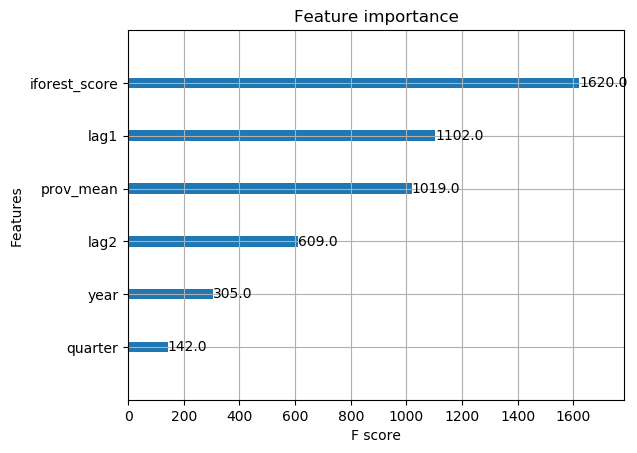

In [44]:
ensemble_trainer = ensemble_model_svc.get_ensemble_trainer(settings)
ensemble_trainer.plot_feature_importance()

In [45]:
ensemble_drop_cols = ['provider_id', 'lag2', 'prov_mean_diff', 'year', 'quarter', 'lag_diff']
ensemble_settings = {
    "drop_cols": ensemble_drop_cols
}

settings = {**settings, **ensemble_settings}

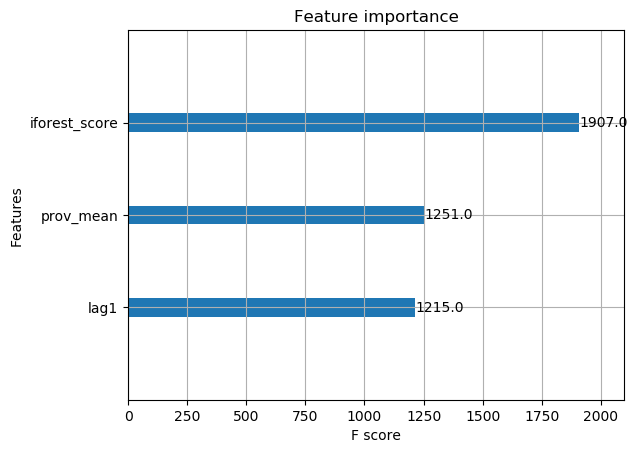

In [46]:
ensemble_trainer = ensemble_model_svc.get_ensemble_trainer(settings)
ensemble_trainer.plot_feature_importance()

### Tuning

In [47]:
candidate = None
# if not SKIP_TUNING:
#     candidate = ensemble_trainer.tune()

In [48]:
candidate

In [49]:
ensemble_trainer.modeling_df

,score,lag1,prov_mean,iforest_score
1,64.0,55.0,55.000000,0.486544
2,44.0,64.0,59.500000,0.524670
3,47.0,44.0,54.333333,0.502059
4,53.0,47.0,52.500000,0.482572
5,33.0,53.0,52.600000,0.568108
...,...,...,...,...
34209,18.0,55.0,55.000000,0.629759
34210,17.0,18.0,36.500000,0.579719
34211,21.0,17.0,30.000000,0.562731
34212,23.0,21.0,27.750000,0.552014


### Model Selection

In [50]:
list_of_runs = glob.glob(f"{settings.get('run_save_path')}/xgbr_ensemble/*.csv")
latest_run = max(list_of_runs, key=os.path.getctime)
print("Using result: ", latest_run)

xgbr_settings = {
    "model_run_data_path": latest_run,
    "model_type": "XGBRegression"
}

settings = {**settings, **xgbr_settings}

Using result:  model_runs/xgbr_ensemble/tuning_results_run_2022-11-26-02h21m.csv


In [51]:
ensemble_model_selector = model_selection_svc.get_model_selector(settings)
ensemble_model_selector.get_top_models()

,mean_test_score,std_test_score,rank_test_score,param_alpha,param_eta,param_gamma,param_max_depth,param_min_child_weight,param_subsample,params
895,-8.3672,0.1181,1,2,0.05,1,7,9,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 1, 'max_dep..."
930,-8.3674,0.1188,2,2,0.05,2,7,9,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 2, 'max_dep..."
860,-8.3686,0.1187,3,2,0.05,0,7,9,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 0, 'max_dep..."
505,-8.3705,0.1272,4,1,0.05,2,7,4,1,"{'alpha': 1, 'eta': 0.05, 'gamma': 2, 'max_dep..."
55,-8.3714,0.1178,5,0,0.05,1,7,9,1,"{'alpha': 0, 'eta': 0.05, 'gamma': 1, 'max_dep..."
855,-8.3721,0.1246,7,2,0.05,0,7,4,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 0, 'max_dep..."
90,-8.3721,0.1194,6,0,0.05,2,7,9,1,"{'alpha': 0, 'eta': 0.05, 'gamma': 2, 'max_dep..."
890,-8.3722,0.1278,8,2,0.05,1,7,4,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 1, 'max_dep..."
859,-8.3726,0.1228,9,2,0.05,0,7,8,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 0, 'max_dep..."
440,-8.3728,0.1194,10,1,0.05,0,7,9,1,"{'alpha': 1, 'eta': 0.05, 'gamma': 0, 'max_dep..."


In [52]:
ensemble_model_index = 930
#ensemble_model_index = ensemble_model_selector.get_top_models().iloc[0].name # default top model
ensemble_model_selector.get_candidate_model_by_index(ensemble_model_index)

mean_fit_time         3.9692
std_fit_time          0.5062
mean_score_time       0.0311
std_score_time        0.0037
param_alpha                2
                       ...  
split48_test_score   -8.2782
split49_test_score   -8.2894
mean_test_score      -8.3674
std_test_score        0.1188
rank_test_score            2
Name: 930, Length: 64, dtype: object

In [53]:
ensemble_model_selector.get_candidate_model_params_by_index(ensemble_model_index)

{'alpha': 2,
 'eta': 0.05,
 'gamma': 2,
 'max_depth': 7,
 'min_child_weight': 9,
 'subsample': 1}

### Final Fit

In [54]:
ensemble_final_fit_settings = {
    "model_type": "XGBRegression",
    "model_dataset_path": settings.get('save_modeling_dataset_path'),
    "xgbr_final_params": ensemble_model_selector.get_candidate_model_params_by_index(ensemble_model_index),
    "drop_cols": ensemble_drop_cols,
}

settings = {**settings, **ensemble_final_fit_settings}

In [55]:
ensemble_fitter = ensemble_model_svc.get_ensemble_final_fitter(settings)
ensemble_model = ensemble_fitter.fit()

In [56]:
ensemble_model

XGBRegressor(alpha=2, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.05,
             eval_metric=None, gamma=2, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0500000007, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=9,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', ...)

### Threshold / AAT Results

In [57]:
threshold_range = range(1,35)

ensemble_aat_res = artificial_anomaly_test_xgb(
    model = ensemble_model,
    model_data = ensemble_fitter.modeling_df,
    selected_features = ['lag1','prov_mean', 'iforest_score'],
    shift_range = range(30,50),
    threshold_range = threshold_range
)[:5]

#ensemble_threshold = ensemble_aat_res.iloc[0]['Threshold']
ensemble_threshold = 12
print("Using Threshold", ensemble_threshold)

ensemble_aat_res

Using Threshold 12


,Threshold,AUROC
10,11,0.764600
11,12,0.763525
9,10,0.762875
12,13,0.757975
8,9,0.756675


In [58]:
settings.get('shift_range')

range(15, 30)

### CV RMSE

In [59]:
ensemble_cv_rmse = None
if not SKIP_RMSE_TEST:
    _, ensemble_cv_rmse = xgbr_test.test_xgbr(ensemble_fitter.modeling_df)
ensemble_cv_rmse

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   53.2s finished


8.4823705087882

## Outcome Analysis

In [60]:
outcome_analysis_settings = {
    "if_model": if_model,
    "if_threshold": if_threshold,

    "xgbr_model": xgbr_model,
    "xgbr_threshold": xgbr_threshold,
    
    "ensemble_model": ensemble_model,
    "ensemble_threshold": ensemble_threshold,
}

settings = {**settings, **outcome_analysis_settings}

In [61]:
ensemble_threshold

12

In [62]:
modeling_dataset = load_dataframe(settings.get('model_dataset_path'), []).dropna(subset = ['lag1'])
modeling_dataset['y_quarter'] = modeling_dataset['year'].astype(str) + 'Q' + modeling_dataset['quarter'].astype(str)
modeling_dataset

,provider_id,score,lag1,lag2,year,quarter,lag_diff,prov_mean,prov_mean_diff,y_quarter
1,100001,64.0,55.0,NaN,2017,2,9.0,55.000000,9.000000,2017Q2
2,100001,44.0,64.0,55.0,2017,3,-20.0,59.500000,-15.500000,2017Q3
3,100001,47.0,44.0,64.0,2017,4,3.0,54.333333,-7.333333,2017Q4
4,100001,53.0,47.0,44.0,2018,1,6.0,52.500000,0.500000,2018Q1
5,100001,33.0,53.0,47.0,2018,2,-20.0,52.600000,-19.600000,2018Q2
...,...,...,...,...,...,...,...,...,...,...
34209,90008,18.0,55.0,NaN,2018,1,-37.0,55.000000,-37.000000,2018Q1
34210,90008,17.0,18.0,55.0,2018,3,-1.0,36.500000,-19.500000,2018Q3
34211,90008,21.0,17.0,18.0,2018,4,4.0,30.000000,-9.000000,2018Q4
34212,90008,23.0,21.0,17.0,2019,1,2.0,27.750000,-4.750000,2019Q1


In [63]:
xgbr_scores = xgbr_model.predict(modeling_dataset[['lag1','prov_mean']])
xgbr_prediction = abs(modeling_dataset['score'] - xgbr_scores) > settings.get('xgbr_threshold')

xgbr_dataset = modeling_dataset.copy()[['score','y_quarter','provider_id','prov_mean','lag_diff','prov_mean_diff']]
xgbr_dataset['outlier'] = xgbr_prediction
xgbr_dataset['model_score'] = xgbr_scores
xgbr_dataset['model'] = "XGBoost Regression"
xgbr_dataset

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,64.0,2017Q2,100001,55.000000,9.0,9.000000,False,58.337082,XGBoost Regression
2,44.0,2017Q3,100001,59.500000,-20.0,-15.500000,True,66.209885,XGBoost Regression
3,47.0,2017Q4,100001,54.333333,3.0,-7.333333,False,48.092991,XGBoost Regression
4,53.0,2018Q1,100001,52.500000,6.0,0.500000,False,50.519848,XGBoost Regression
5,33.0,2018Q2,100001,52.600000,-20.0,-19.600000,True,55.874847,XGBoost Regression
...,...,...,...,...,...,...,...,...,...
34209,18.0,2018Q1,90008,55.000000,-37.0,-37.000000,True,58.337082,XGBoost Regression
34210,17.0,2018Q3,90008,36.500000,-1.0,-19.500000,False,25.361094,XGBoost Regression
34211,21.0,2018Q4,90008,30.000000,4.0,-9.000000,False,23.089663,XGBoost Regression
34212,23.0,2019Q1,90008,27.750000,2.0,-4.750000,False,25.992102,XGBoost Regression


In [64]:
if_scores = if_model.score_samples(modeling_dataset.drop(columns=[*if_drop_cols, 'y_quarter'])) * -1
if_prediction = if_scores > settings.get('if_threshold')

if_dataset = modeling_dataset.copy()[['score', 'y_quarter','provider_id','prov_mean','lag_diff','prov_mean_diff']]
if_dataset['outlier'] = if_prediction
if_dataset['model_score'] = if_scores
if_dataset['model'] = "Isolation Forest"
if_dataset

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,64.0,2017Q2,100001,55.000000,9.0,9.000000,False,0.486544,Isolation Forest
2,44.0,2017Q3,100001,59.500000,-20.0,-15.500000,True,0.524670,Isolation Forest
3,47.0,2017Q4,100001,54.333333,3.0,-7.333333,False,0.502059,Isolation Forest
4,53.0,2018Q1,100001,52.500000,6.0,0.500000,False,0.482572,Isolation Forest
5,33.0,2018Q2,100001,52.600000,-20.0,-19.600000,True,0.568108,Isolation Forest
...,...,...,...,...,...,...,...,...,...
34209,18.0,2018Q1,90008,55.000000,-37.0,-37.000000,True,0.629759,Isolation Forest
34210,17.0,2018Q3,90008,36.500000,-1.0,-19.500000,True,0.579719,Isolation Forest
34211,21.0,2018Q4,90008,30.000000,4.0,-9.000000,True,0.562731,Isolation Forest
34212,23.0,2019Q1,90008,27.750000,2.0,-4.750000,True,0.552014,Isolation Forest


In [65]:
ensemble_dataset = modeling_dataset.copy()[['lag1','prov_mean','score']]
ensemble_dataset['iforest_scores'] = if_scores
ensemble_scores = ensemble_model.predict(ensemble_dataset[['lag1','prov_mean','iforest_scores']])
ensemble_prediction = abs(ensemble_dataset['score'] - ensemble_scores) > settings.get('ensemble_threshold')

ensemble_dataset = modeling_dataset.copy()[['score', 'y_quarter', 'provider_id','prov_mean','lag_diff','prov_mean_diff']]
ensemble_dataset['outlier'] = ensemble_prediction
ensemble_dataset['model_score'] = ensemble_scores
ensemble_dataset['model'] = "Ensemble Model"
ensemble_dataset

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,64.0,2017Q2,100001,55.000000,9.0,9.000000,False,58.887775,Ensemble Model
2,44.0,2017Q3,100001,59.500000,-20.0,-15.500000,True,68.103012,Ensemble Model
3,47.0,2017Q4,100001,54.333333,3.0,-7.333333,False,48.159546,Ensemble Model
4,53.0,2018Q1,100001,52.500000,6.0,0.500000,False,49.512951,Ensemble Model
5,33.0,2018Q2,100001,52.600000,-20.0,-19.600000,True,56.005791,Ensemble Model
...,...,...,...,...,...,...,...,...,...
34209,18.0,2018Q1,90008,55.000000,-37.0,-37.000000,False,17.782072,Ensemble Model
34210,17.0,2018Q3,90008,36.500000,-1.0,-19.500000,False,24.367777,Ensemble Model
34211,21.0,2018Q4,90008,30.000000,4.0,-9.000000,False,20.355694,Ensemble Model
34212,23.0,2019Q1,90008,27.750000,2.0,-4.750000,False,24.871571,Ensemble Model


In [66]:
import pandas as pd

comparison_df = pd.concat([xgbr_dataset, if_dataset, ensemble_dataset], axis = 0)
comparison_df['model'] = comparison_df['model'].astype('category')
comparison_df['model'] = comparison_df['model'].cat.reorder_categories(['XGBoost Regression','Isolation Forest', 'Ensemble Model'])
comparison_df

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,64.0,2017Q2,100001,55.000000,9.0,9.000000,False,58.337082,XGBoost Regression
2,44.0,2017Q3,100001,59.500000,-20.0,-15.500000,True,66.209885,XGBoost Regression
3,47.0,2017Q4,100001,54.333333,3.0,-7.333333,False,48.092991,XGBoost Regression
4,53.0,2018Q1,100001,52.500000,6.0,0.500000,False,50.519848,XGBoost Regression
5,33.0,2018Q2,100001,52.600000,-20.0,-19.600000,True,55.874847,XGBoost Regression
...,...,...,...,...,...,...,...,...,...
34209,18.0,2018Q1,90008,55.000000,-37.0,-37.000000,False,17.782072,Ensemble Model
34210,17.0,2018Q3,90008,36.500000,-1.0,-19.500000,False,24.367777,Ensemble Model
34211,21.0,2018Q4,90008,30.000000,4.0,-9.000000,False,20.355694,Ensemble Model
34212,23.0,2019Q1,90008,27.750000,2.0,-4.750000,False,24.871571,Ensemble Model


### CV RMSE

#### XGBoost Regression

In [67]:
xgbr_cv_rmse

9.543612659227394

#### Ensemble Model

In [68]:
ensemble_cv_rmse

8.4823705087882

### Insample RMSE

#### XGBoost Regression

In [69]:
rmse = np.sqrt(np.mean((xgbr_dataset['score'] - xgbr_dataset['model_score'])**2))
mae = np.sqrt(np.mean(abs(xgbr_dataset['score'] - xgbr_dataset['model_score'])))

pd.DataFrame({"RMSE":rmse, "MAE":mae}, index = [0])

,RMSE,MAE
0,9.196205,2.575195


#### Ensemble Model

In [70]:
rmse = np.sqrt(np.mean((ensemble_dataset['score'] - ensemble_dataset['model_score'])**2))
mae = np.sqrt(np.mean(abs(ensemble_dataset['score'] - ensemble_dataset['model_score'])))

pd.DataFrame({"RMSE":rmse, "MAE":mae}, index = [0])

,RMSE,MAE
0,7.485157,2.358394


In [71]:
display(comparison_df[['outlier', 'score','model']]
     .rename(columns = {'outlier':'Predicted Outlier',
                        'score':'Score',
                        'model':'Model'})
     .groupby(['Predicted Outlier', 'Model'])
     .describe(percentiles = [.1, .25, .5, .75, .9])
     .transpose()
    .round(1)
)

Predicted Outlier              False                                  \
Model             XGBoost Regression Isolation Forest Ensemble Model   
Score count                  27135.0          24707.0        28577.0   
      mean                      74.6             77.1           73.9   
      std                       17.7             13.1           18.3   
      min                        2.0             36.0            2.0   
      10%                       50.0             58.0           48.0   
      25%                       65.0             68.0           64.0   
      50%                       78.0             79.0           78.0   
      75%                       88.0             87.0           87.0   
      90%                       93.0             93.0           94.0   
      max                      100.0            100.0          100.0   

Predicted Outlier               True                                  
Model             XGBoost Regression Isolation Forest Ensemble Model  
Score count                   4490.0           6918.0         3048.0  
      mean                      65.0             59.2           66.5  
      std                       23.4             27.8           22.9  
      min                        2.0              2.0            2.0  
      10%                       33.0             24.0           33.0  
      25%                       48.0             36.0           50.0  
      50%                       67.0             55.0           69.0  
      75%                       84.0             88.0           86.0  
      90%                       94.0            100.0           93.0  
      max                      100.0            100.0          100.0

In [72]:
xgb = comparison_df.query('model == "XGBoost Regression"')

summary_table = pd.DataFrame({"outlier count": xgb.loc[ xgb['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": xgb['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier
2014Q2,117,795,14.72
2014Q3,111,842,13.18
2015Q1,229,836,27.39
2015Q2,125,963,12.98
2015Q3,109,995,10.95
2015Q4,145,1109,13.07
2016Q1,248,2090,11.87
2016Q3,290,1228,23.62
2016Q4,163,1317,12.38
2017Q1,168,1350,12.44


### Isolation Forest Outlier Counts by Quarter

In [73]:
iforest = comparison_df.query('model == "Isolation Forest"')

summary_table = pd.DataFrame({"outlier count": iforest.loc[ iforest['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": iforest['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier
2014Q2,217,795,27.30
2014Q3,212,842,25.18
2015Q1,290,836,34.69
2015Q2,240,963,24.92
2015Q3,236,995,23.72
2015Q4,247,1109,22.27
2016Q1,388,2090,18.56
2016Q3,339,1228,27.61
2016Q4,276,1317,20.96
2017Q1,267,1350,19.78


### Ensemble Model Outlier Counts by Quarter

In [74]:
ensemble = comparison_df.query('model == "Ensemble Model"')

summary_table = pd.DataFrame({"outlier count": ensemble.loc[ ensemble['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": ensemble['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier
2014Q2,95,795,11.95
2014Q3,89,842,10.57
2015Q1,149,836,17.82
2015Q2,75,963,7.79
2015Q3,65,995,6.53
2015Q4,96,1109,8.66
2016Q1,174,2090,8.33
2016Q3,194,1228,15.80
2016Q4,103,1317,7.82
2017Q1,117,1350,8.67


In [75]:
outlier_comparison = comparison_df.query('model == "Ensemble Model"')[['outlier', 'lag_diff', 'prov_mean_diff']].copy()
outlier_comparison[['lag_diff', 'prov_mean_diff']] = abs(outlier_comparison[['lag_diff', 'prov_mean_diff']])
outlier_comparison = outlier_comparison.rename(columns = {'lag_diff':'Difference from Previous Score',
                                                          'prov_mean_diff': 'Difference from Provider Mean Score',
                                                          'outlier': 'Predicted Anomaly'})
outlier_comparison.groupby('Predicted Anomaly').describe(percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).loc[:,(slice(None),['mean','std','1%', '10%', '25%', '50%', '75%','90%','99%'])].transpose()


Predicted Anomaly                             False       True
Difference from Previous Score      mean   5.411275  18.855315
                                    std    5.537486   8.278092
                                    1%     0.000000   8.000000
                                    10%    0.000000  11.000000
                                    25%    2.000000  14.000000
                                    50%    4.000000  17.000000
                                    75%    8.000000  21.000000
                                    90%   11.000000  28.000000
                                    99%   28.000000  51.000000
Difference from Provider Mean Score mean   9.692922  16.731633
                                    std    8.603605  10.274447
                                    1%     0.000000   0.571429
                                    10%    1.250000   5.156680
                                    25%    3.428571  10.000000
                                    50%    7.500000  15.369318
                                    75%   13.428571  21.500000
                                    90%   21.079487  28.666667
                                    99%   39.684800  54.205972

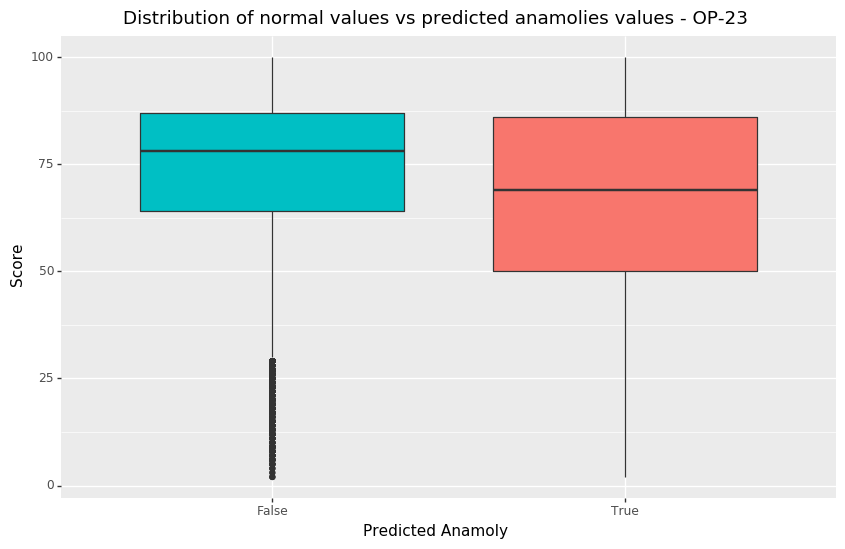

<ggplot: (8746893725701)>

In [110]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model"'),
        aes(x = 'outlier',
            y = 'score',
            fill = 'outlier'))
 + ggtitle("Distribution of normal values vs predicted anamolies values - OP-23")
 + ylab("Score")
 + xlab("Predicted Anamoly")
 + labs(fill = 'Predicted Anamoly')
 + geom_boxplot(show_legend = False)
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
)

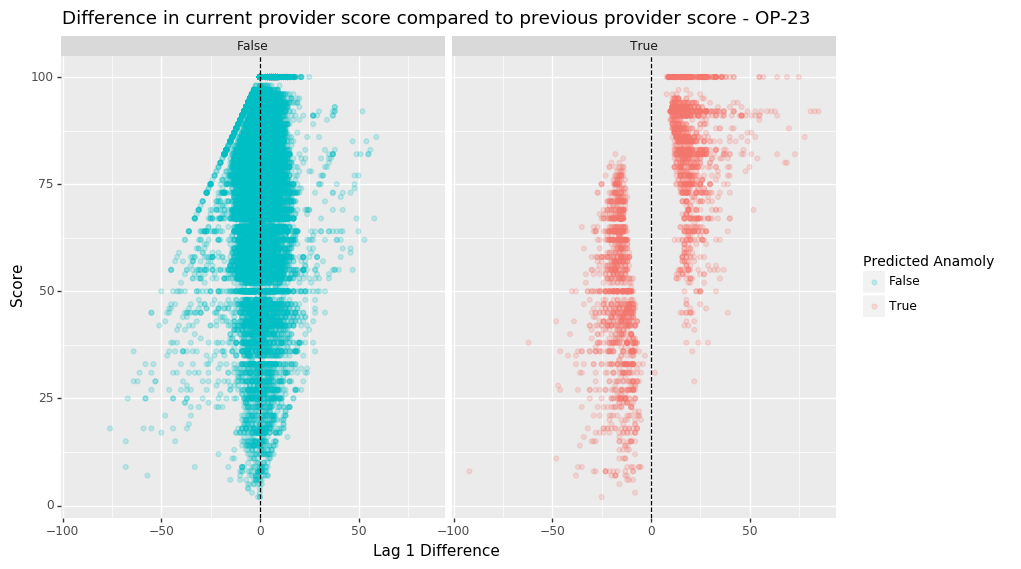

<ggplot: (8746893732357)>

In [77]:
(ggplot(comparison_df.query('model == "Ensemble Model"'),     
        aes(x = 'lag_diff', 
            y = 'score',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Difference in current provider score compared to previous provider score - OP-23")
 + xlab("Lag 1 Difference")
 + ylab("Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_point(alpha = 0.2)
 + geom_vline(xintercept = 0, linetype = 'dashed')
 + facet_wrap('~outlier')
 + theme(legend_title = element_text(size = 10))
)

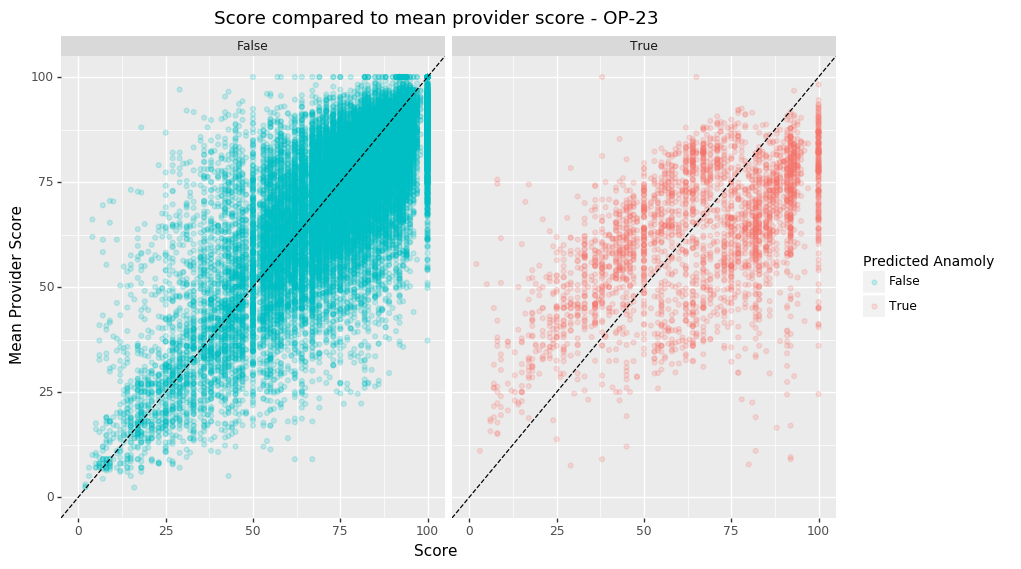

<ggplot: (8746893734049)>

In [78]:
(ggplot(comparison_df.query('model == "Ensemble Model"'),
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score - OP-23")
 + geom_point(size = 1.5, alpha = 0.2)
 + xlim(0,100)
 + ylim(0,100)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~outlier')
 + theme(legend_title = element_text(size = 10))
)

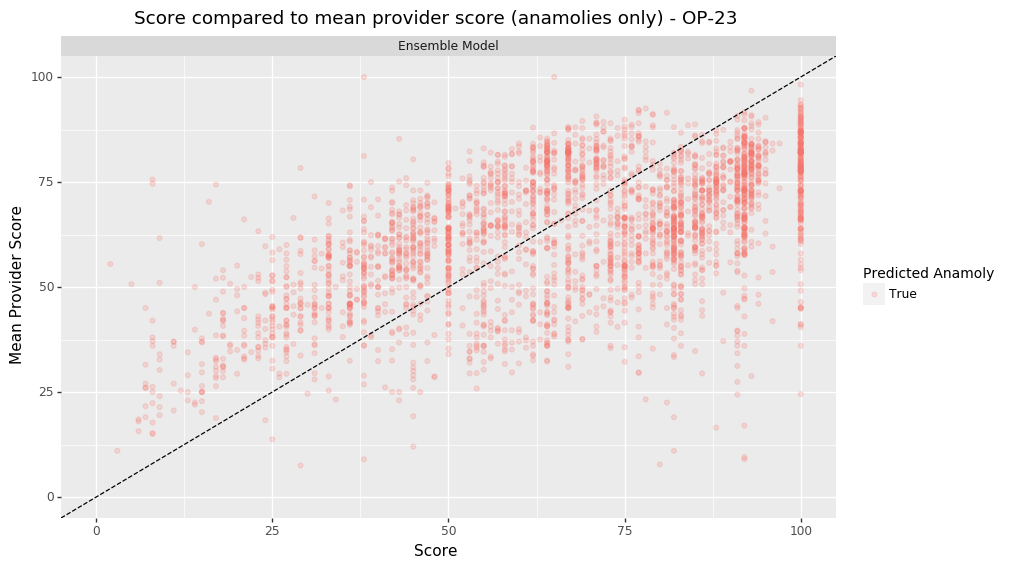

<ggplot: (8746893750213)>

In [79]:
(ggplot(comparison_df.query('model == "Ensemble Model" and outlier == True'),
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score (anamolies only) - OP-23")
 + geom_point(size = 1.5, alpha = 0.2)
 + xlim(0,100)
 + ylim(0,100)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
)

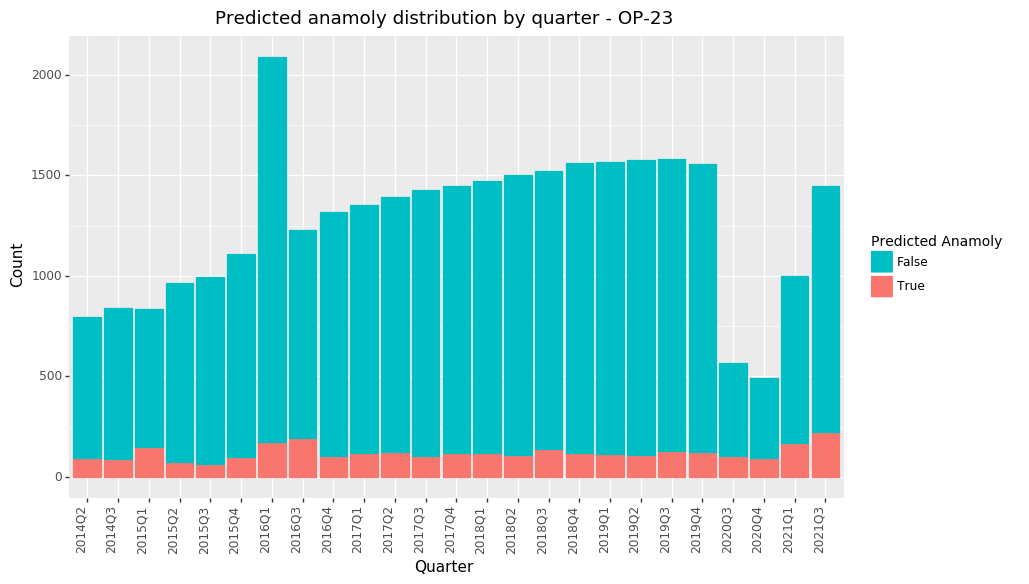

<ggplot: (8746893383865)>

In [109]:
(ggplot(comparison_df.query('model == "Ensemble Model"'),     
        aes(x = 'y_quarter',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Predicted anamoly distribution by quarter - OP-23")
 + xlab("Quarter")
 + ylab("Count")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_bar()
 + theme(axis_text_x = element_text(rotation=90, hjust=1))
 + theme(legend_title = element_text(size = 10))
)

In [81]:
comparison_df.query('model == "Ensemble Model"')

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,64.0,2017Q2,100001,55.000000,9.0,9.000000,False,58.887775,Ensemble Model
2,44.0,2017Q3,100001,59.500000,-20.0,-15.500000,True,68.103012,Ensemble Model
3,47.0,2017Q4,100001,54.333333,3.0,-7.333333,False,48.159546,Ensemble Model
4,53.0,2018Q1,100001,52.500000,6.0,0.500000,False,49.512951,Ensemble Model
5,33.0,2018Q2,100001,52.600000,-20.0,-19.600000,True,56.005791,Ensemble Model
...,...,...,...,...,...,...,...,...,...
34209,18.0,2018Q1,90008,55.000000,-37.0,-37.000000,False,17.782072,Ensemble Model
34210,17.0,2018Q3,90008,36.500000,-1.0,-19.500000,False,24.367777,Ensemble Model
34211,21.0,2018Q4,90008,30.000000,4.0,-9.000000,False,20.355694,Ensemble Model
34212,23.0,2019Q1,90008,27.750000,2.0,-4.750000,False,24.871571,Ensemble Model


## Comparison with Previous Run

In [82]:
from xgboost import XGBRegressor
import pickle

def load_and_predict(id_num, dataset, model_storage_path): 
    model_filename = os.path.join(model_storage_path, "model_id" + str(id_num) + ".pkl")
    if_model = pickle.load(open(model_filename, 'rb'))
    
    #results = if_model.predict(dataset)
    results = if_model.score_samples(dataset) * -1
    
    return results

filtered_path = "/root/HAIP/notebooks/op-23-models/isolation-forest/test_output_data.csv"
dataset = pd.read_csv(filtered_path)

In [83]:
dataset[['year', 'quarter']] = dataset['y_quarter'].str.split("Q",expand=True)
dataset['year'] = dataset['year'].astype(int)
dataset['quarter'] = dataset['quarter'].astype(int)

In [84]:
final_params = {
    'alpha': 2,
    'eta': 0.1,
    'gamma': 2,
    'max_depth': 5,
    'min_child_weight': 8,
    'subsample': 0.8999999999999999
}

model = XGBRegressor(**final_params)
X, y = dataset[['year', 'quarter', 'lag1']], dataset[['score']]
model.fit(X, y)

XGBRegressor(alpha=2, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=2, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=8,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', ...)

In [85]:
xgb_predicted_score = model.predict(X)
xgb_outlier_prediction = (abs(y['score'] - xgb_predicted_score) > 15)
xgb_sep01_dataset = dataset.copy()[['score', 'lag1','y_quarter', 'year','quarter','providerId']]
xgb_sep01_dataset['outlier'] = xgb_outlier_prediction
xgb_sep01_dataset['lag1_diff'] = dataset['score'] - dataset['lag1']
xgb_sep01_dataset['model'] = "Previous XGBoost Regression"

### Insample RMSE

||New XGBoost Ensemble|Prev XGBoost Regression|
|---|---|---|
|In-sample RMSE|7.49|8.12|
|In-sample MAE|2.36|2.32|

#### XGBoost Regression

In [86]:
rmse = np.sqrt(np.mean((xgbr_dataset['score'] - xgbr_dataset['model_score'])**2))
mae = np.sqrt(np.mean(abs(xgbr_dataset['score'] - xgbr_dataset['model_score'])))

pd.DataFrame({"RMSE":rmse, "MAE":mae}, index = [0])

,RMSE,MAE
0,9.196205,2.575195


#### Ensemble Model

In [87]:
rmse = np.sqrt(np.mean((ensemble_dataset['score'] - ensemble_dataset['model_score'])**2))
mae = np.sqrt(np.mean(abs(ensemble_dataset['score'] - ensemble_dataset['model_score'])))

pd.DataFrame({"RMSE":rmse, "MAE":mae}, index = [0])

,RMSE,MAE
0,7.485157,2.358394


In [88]:
# xgb_sep01_dataset

#### Previous XG Boost Regression

In [89]:
# rmse = np.sqrt(np.mean((xgb_sep01_dataset['score'] - xgb_sep01_dataset['predicted_score'])**2))
# mae = np.sqrt(np.mean(abs(xgb_sep01_dataset['score'] - xgb_sep01_dataset['predicted_score'])))

# pd.DataFrame({"RMSE":rmse, "MAE":mae}, index = [0])

In [90]:
model_storage_path = '/root/HAIP/notebooks/op-23-models/isolation-forest/candidate_models/run_2022-10-18-19h39m/'

if_outlier_prediction = load_and_predict(36, dataset.drop(columns = ['y_quarter', 'year', 'quarter', 'providerId', 'lag1']), model_storage_path)
if_sep01_dataset = dataset.copy()[['score', 'lag1','y_quarter', 'year', 'quarter','providerId']]
if_sep01_dataset['outlier'] = if_outlier_prediction > 0.59
if_sep01_dataset['lag1_diff'] = if_sep01_dataset['score'] - if_sep01_dataset['lag1']
if_sep01_dataset['model'] = "Isolation Forest"

if_sep01_dataset[['year', 'quarter']] = if_sep01_dataset['y_quarter'].str.split("Q",expand=True)
if_sep01_dataset['year'] = if_sep01_dataset['year'].astype(int)
if_sep01_dataset['quarter'] = if_sep01_dataset['quarter'].astype(int)

In [91]:
old_comparison_df = pd.concat([xgb_sep01_dataset, if_sep01_dataset], axis = 0)
xgb_sep01_dataset['predicted_score'] = xgb_predicted_score

provider_means = (
    dataset
    .groupby('providerId')['score']
    .mean()
    .reset_index()
    .rename(columns = {'score':'provider_mean_score'})
)

old_comparison_df = old_comparison_df.merge(provider_means, how = 'left', on = 'providerId')
old_comparison_df['prov_mean_diff'] = old_comparison_df['score'] - old_comparison_df['provider_mean_score']
old_comparison_df = old_comparison_df.rename({'lag1':'lag', 'lag1_diff':'lag_diff', 'providerId':'provider_id', 'provider_mean_score':'prov_mean'}, axis = 1)

In [92]:
combined_comparison_df = comparison_df.copy()

In [93]:
comparison_df['Iteration'] = 'New'
old_comparison_df['Iteration'] = 'Previous'
combined_comparison_df = pd.concat([comparison_df, old_comparison_df], axis = 0)
combined_comparison_df

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model,Iteration,lag,year,quarter
1,64.0,2017Q2,100001,55.000000,9.0,9.000000,False,58.337082,XGBoost Regression,New,NaN,NaN,NaN
2,44.0,2017Q3,100001,59.500000,-20.0,-15.500000,True,66.209885,XGBoost Regression,New,NaN,NaN,NaN
3,47.0,2017Q4,100001,54.333333,3.0,-7.333333,False,48.092991,XGBoost Regression,New,NaN,NaN,NaN
4,53.0,2018Q1,100001,52.500000,6.0,0.500000,False,50.519848,XGBoost Regression,New,NaN,NaN,NaN
5,33.0,2018Q2,100001,52.600000,-20.0,-19.600000,True,55.874847,XGBoost Regression,New,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80877,69.0,2020Q3,670124,68.272727,15.0,0.727273,False,NaN,Isolation Forest,Previous,54.0,2020.0,3.0
80878,100.0,2020Q4,670124,68.272727,31.0,31.727273,False,NaN,Isolation Forest,Previous,69.0,2020.0,4.0
80879,83.0,2021Q1,670124,68.272727,-17.0,14.727273,False,NaN,Isolation Forest,Previous,100.0,2021.0,1.0
80880,83.0,2021Q1,670124,68.272727,0.0,14.727273,False,NaN,Isolation Forest,Previous,83.0,2021.0,1.0


In [94]:
display(comparison_df[['outlier', 'score','model']]
     .rename(columns = {'outlier':'Predicted Outlier',
                        'score':'Score',
                        'model':'Model'})
     .groupby(['Predicted Outlier', 'Model'])
     .describe(percentiles = [.1, .25, .5, .75, .9])
     .transpose()
    .round(1)
)

Predicted Outlier              False                                  \
Model             XGBoost Regression Isolation Forest Ensemble Model   
Score count                  27135.0          24707.0        28577.0   
      mean                      74.6             77.1           73.9   
      std                       17.7             13.1           18.3   
      min                        2.0             36.0            2.0   
      10%                       50.0             58.0           48.0   
      25%                       65.0             68.0           64.0   
      50%                       78.0             79.0           78.0   
      75%                       88.0             87.0           87.0   
      90%                       93.0             93.0           94.0   
      max                      100.0            100.0          100.0   

Predicted Outlier               True                                  
Model             XGBoost Regression Isolation Forest Ensemble Model  
Score count                   4490.0           6918.0         3048.0  
      mean                      65.0             59.2           66.5  
      std                       23.4             27.8           22.9  
      min                        2.0              2.0            2.0  
      10%                       33.0             24.0           33.0  
      25%                       48.0             36.0           50.0  
      50%                       67.0             55.0           69.0  
      75%                       84.0             88.0           86.0  
      90%                       94.0            100.0           93.0  
      max                      100.0            100.0          100.0

In [95]:
xgb = combined_comparison_df.query('model == "XGBoost Regression" and Iteration == "Previous"')

summary_table = pd.DataFrame({"outlier count": xgb.loc[ xgb['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": xgb['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier


In [96]:
iforest = combined_comparison_df.query('model == "XGBoost Regression" and Iteration == "Previous"')

summary_table = pd.DataFrame({"outlier count": iforest.loc[ iforest['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": iforest['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier


In [97]:
combined_comparison_df

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model,Iteration,lag,year,quarter
1,64.0,2017Q2,100001,55.000000,9.0,9.000000,False,58.337082,XGBoost Regression,New,NaN,NaN,NaN
2,44.0,2017Q3,100001,59.500000,-20.0,-15.500000,True,66.209885,XGBoost Regression,New,NaN,NaN,NaN
3,47.0,2017Q4,100001,54.333333,3.0,-7.333333,False,48.092991,XGBoost Regression,New,NaN,NaN,NaN
4,53.0,2018Q1,100001,52.500000,6.0,0.500000,False,50.519848,XGBoost Regression,New,NaN,NaN,NaN
5,33.0,2018Q2,100001,52.600000,-20.0,-19.600000,True,55.874847,XGBoost Regression,New,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80877,69.0,2020Q3,670124,68.272727,15.0,0.727273,False,NaN,Isolation Forest,Previous,54.0,2020.0,3.0
80878,100.0,2020Q4,670124,68.272727,31.0,31.727273,False,NaN,Isolation Forest,Previous,69.0,2020.0,4.0
80879,83.0,2021Q1,670124,68.272727,-17.0,14.727273,False,NaN,Isolation Forest,Previous,100.0,2021.0,1.0
80880,83.0,2021Q1,670124,68.272727,0.0,14.727273,False,NaN,Isolation Forest,Previous,83.0,2021.0,1.0


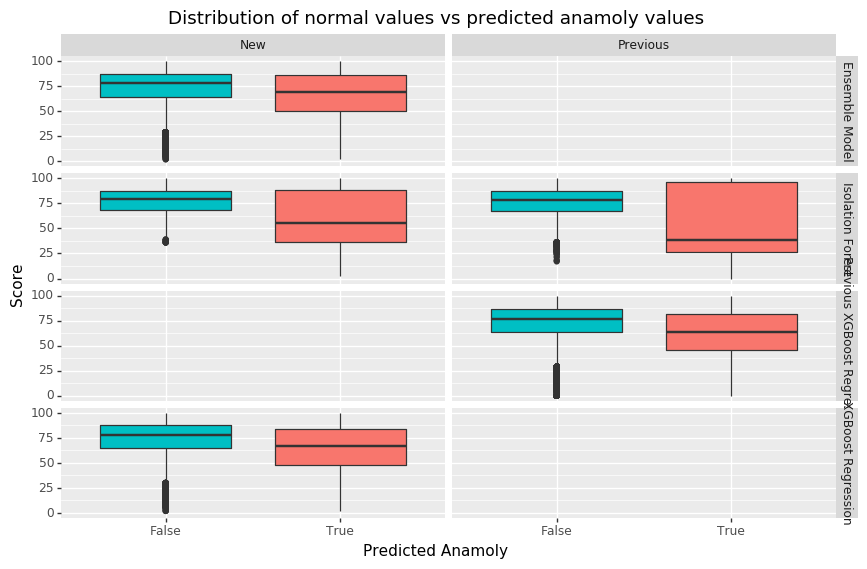

<ggplot: (8746922066149)>

In [98]:
plotnine.options.figure_size = (10,6)
(ggplot(combined_comparison_df,     
        aes(x = 'outlier',
            y = 'score',
            fill = 'outlier'))
 + ggtitle("Distribution of normal values vs predicted anamoly values")
 + ylab("Score")
 + xlab("Predicted Anamoly")
 + labs(fill = 'Predicted Anamoly')
 + geom_boxplot(show_legend = False)
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + facet_grid('model~Iteration')
)

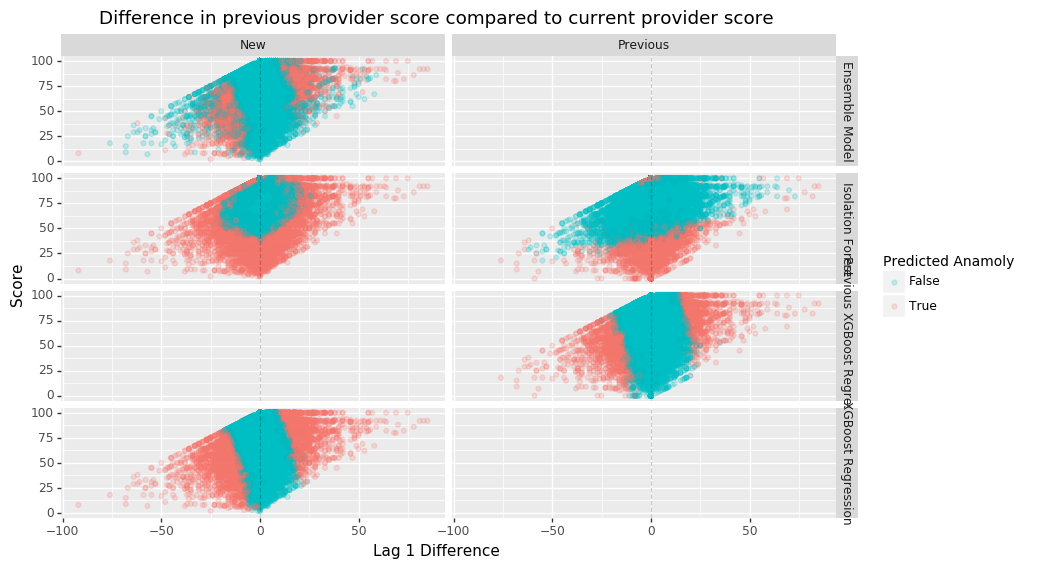

<ggplot: (8746893377073)>

In [99]:
plotnine.options.figure_size = (10,6)
(ggplot(combined_comparison_df,     
        aes(x = 'lag_diff', 
            y = 'score',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Difference in previous provider score compared to current provider score")
 + xlab("Lag 1 Difference")
 + ylab("Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_point(alpha = 0.2)
 + geom_vline(xintercept = 0, linetype = 'dashed', alpha = 0.2)
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
 + facet_grid('model~Iteration')
)

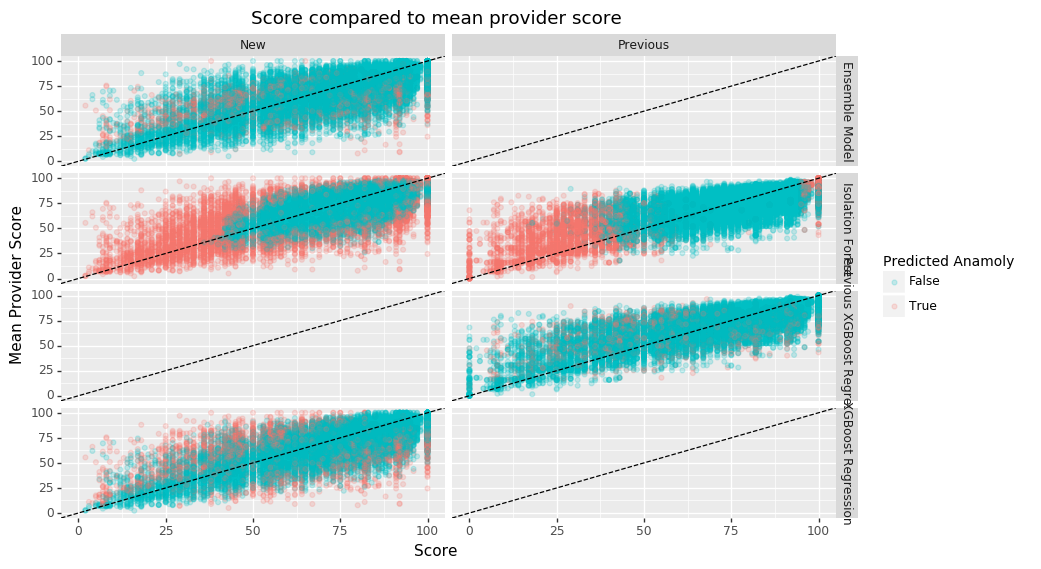

<ggplot: (8746891507937)>

In [100]:
plotnine.options.figure_size = (10,6)
(ggplot(combined_comparison_df,
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score")
 + geom_point(size = 1.5, alpha = 0.2)
 + xlim(0,100)
 + ylim(0,100)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
 + facet_grid('model~Iteration')
)

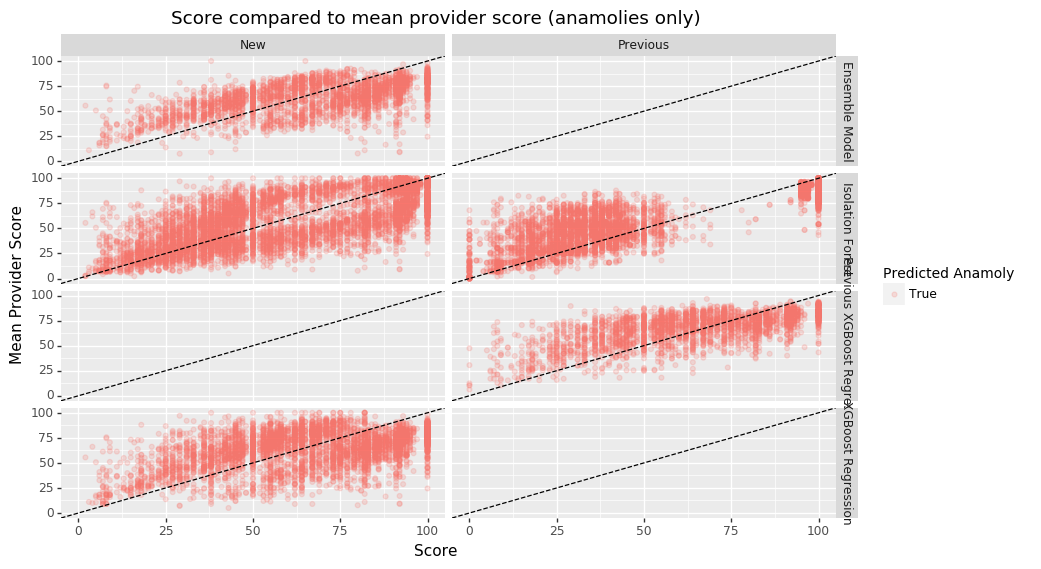

<ggplot: (8746891276797)>

In [101]:
plotnine.options.figure_size = (10,6)
(ggplot(combined_comparison_df[combined_comparison_df['outlier'] == True],
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score (anamolies only)")
 + geom_point(size = 1.5, alpha = 0.2)
 + xlim(0,100)
 + ylim(0,100)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
 + facet_grid('model~Iteration')
)

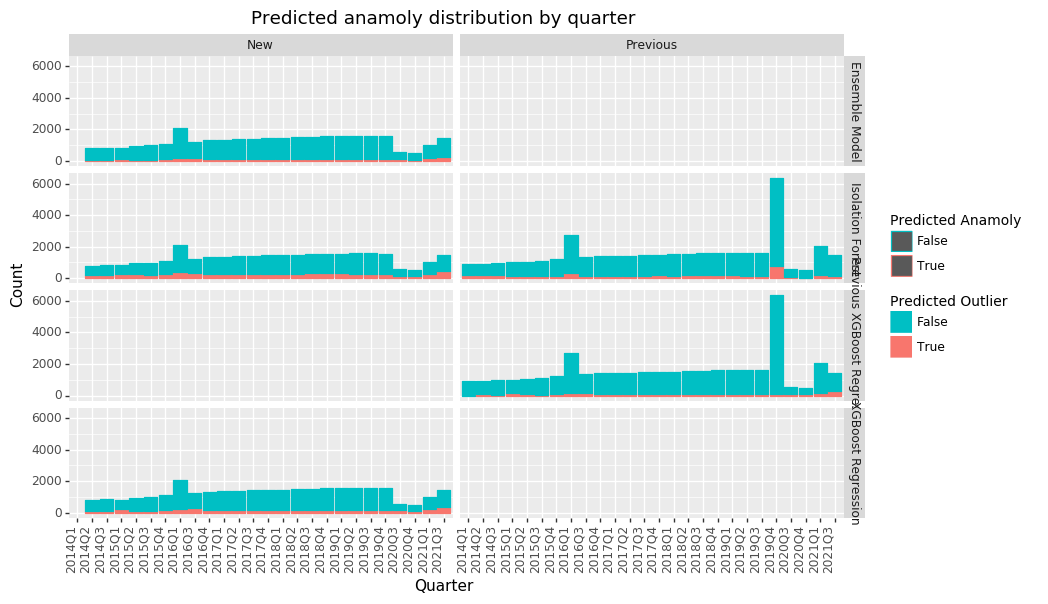

<ggplot: (8746876974433)>

In [102]:
plotnine.options.figure_size = (10,6)
(ggplot(combined_comparison_df,     
        aes(x = 'y_quarter',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Predicted anamoly distribution by quarter")
 + xlab("Quarter")
 + ylab("Count")
 + labs(fill = 'Predicted Outlier', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_bar()
 + theme(axis_text_x = element_text(rotation=90, hjust=1))
 + facet_grid('model~Iteration')
 + theme(legend_title = element_text(size = 10))
)

## Ensemble vs Regression

In [103]:
versus_comparison_df = combined_comparison_df[
    ((combined_comparison_df['model'] == 'Ensemble Model') & (combined_comparison_df['Iteration'] == 'New')) |
    ((combined_comparison_df['model'] == 'Previous XGBoost Regression') & (combined_comparison_df['Iteration'] == 'Previous'))
]

versus_comparison_df

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model,Iteration,lag,year,quarter
1,64.0,2017Q2,100001,55.000000,9.0,9.000000,False,58.887775,Ensemble Model,New,NaN,NaN,NaN
2,44.0,2017Q3,100001,59.500000,-20.0,-15.500000,True,68.103012,Ensemble Model,New,NaN,NaN,NaN
3,47.0,2017Q4,100001,54.333333,3.0,-7.333333,False,48.159546,Ensemble Model,New,NaN,NaN,NaN
4,53.0,2018Q1,100001,52.500000,6.0,0.500000,False,49.512951,Ensemble Model,New,NaN,NaN,NaN
5,33.0,2018Q2,100001,52.600000,-20.0,-19.600000,True,56.005791,Ensemble Model,New,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40436,69.0,2020Q3,670124,68.272727,15.0,0.727273,False,NaN,Previous XGBoost Regression,Previous,54.0,2020.0,3.0
40437,100.0,2020Q4,670124,68.272727,31.0,31.727273,True,NaN,Previous XGBoost Regression,Previous,69.0,2020.0,4.0
40438,83.0,2021Q1,670124,68.272727,-17.0,14.727273,False,NaN,Previous XGBoost Regression,Previous,100.0,2021.0,1.0
40439,83.0,2021Q1,670124,68.272727,0.0,14.727273,False,NaN,Previous XGBoost Regression,Previous,83.0,2021.0,1.0


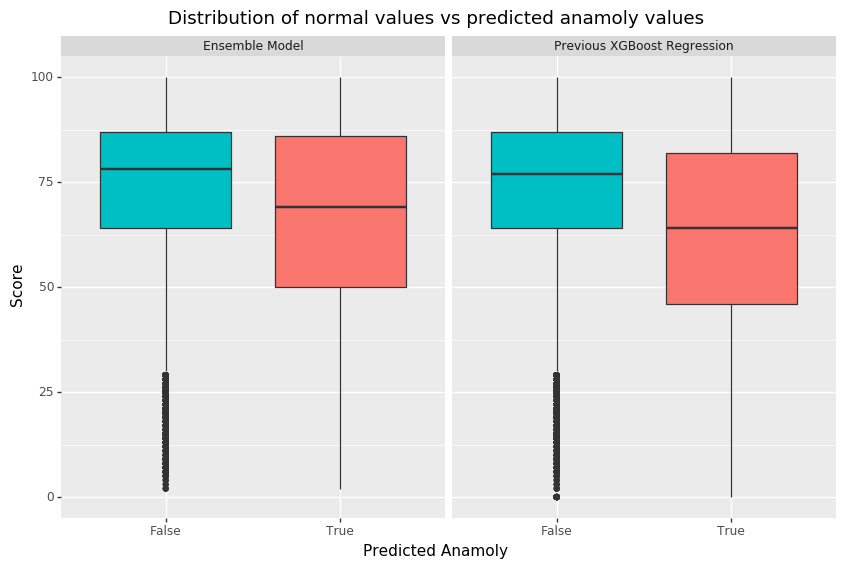

<ggplot: (8746876553485)>

In [104]:
plotnine.options.figure_size = (10,6)
(ggplot(versus_comparison_df,     
        aes(x = 'outlier',
            y = 'score',
            fill = 'outlier'))
 + ggtitle("Distribution of normal values vs predicted anamoly values")
 + ylab("Score")
 + xlab("Predicted Anamoly")
 + labs(fill = 'Predicted Anamoly')
 + geom_boxplot(show_legend = False)
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + facet_wrap('~model')
)

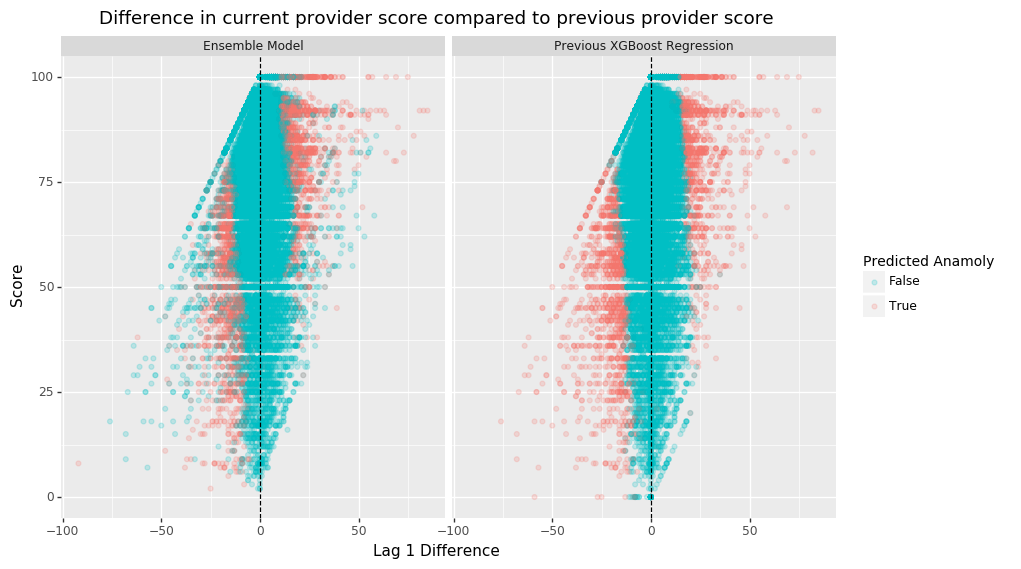

<ggplot: (8746876581109)>

In [105]:
plotnine.options.figure_size = (10,6)
(ggplot(versus_comparison_df,     
        aes(x = 'lag_diff', 
            y = 'score',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Difference in current provider score compared to previous provider score")
 + xlab("Lag 1 Difference")
 + ylab("Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_point(alpha = 0.2)
 + geom_vline(xintercept = 0, linetype = 'dashed')
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
)

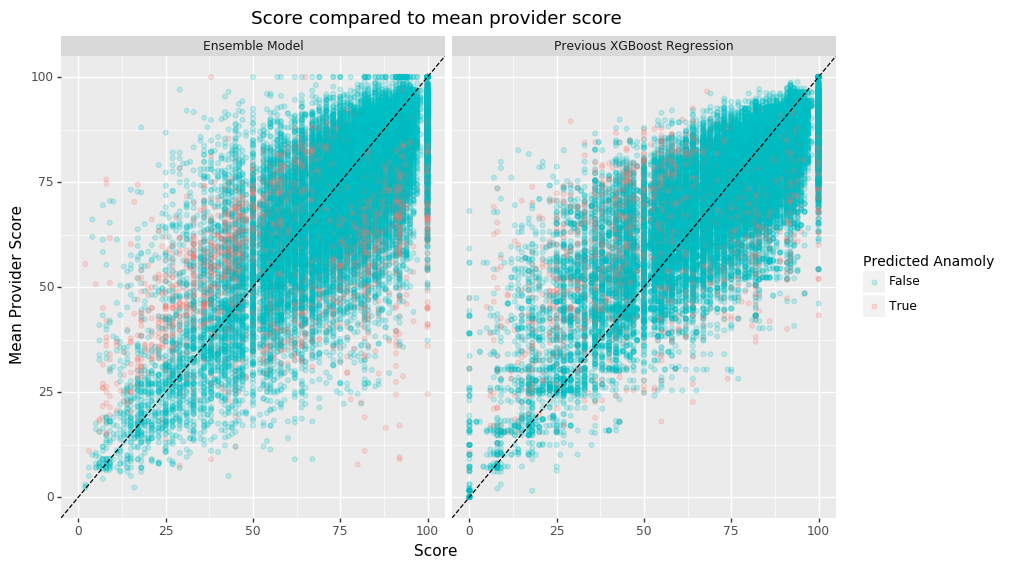

<ggplot: (8746890691645)>

In [106]:
plotnine.options.figure_size = (10,6)
(ggplot(versus_comparison_df,
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score")
 + geom_point(size = 1.5, alpha = 0.2)
 + xlim(0,100)
 + ylim(0,100)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
)

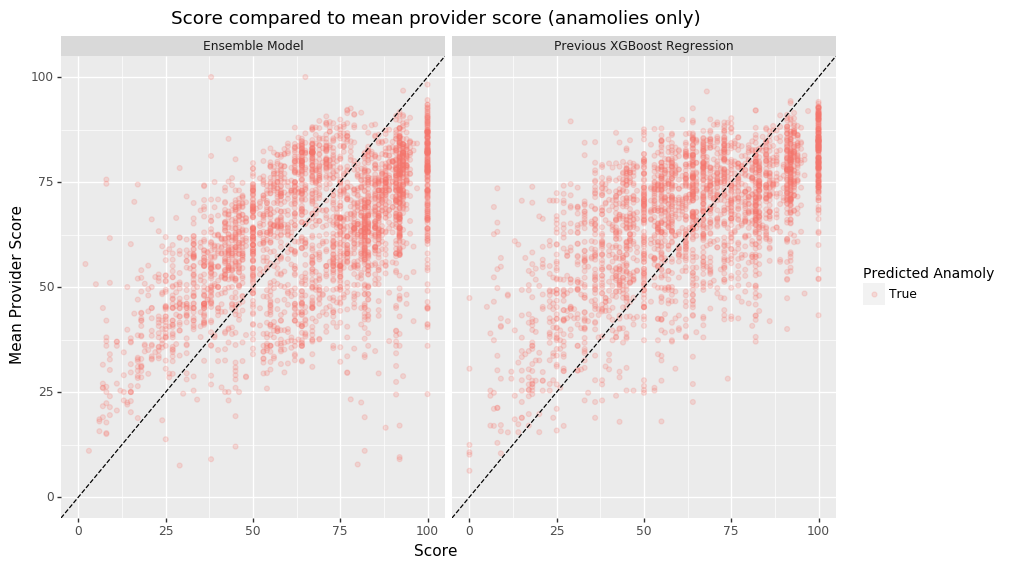

<ggplot: (8746922077721)>

In [107]:
plotnine.options.figure_size = (10,6)
(ggplot(versus_comparison_df[versus_comparison_df['outlier'] == True],
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score (anamolies only)")
 + geom_point(size = 1.5, alpha = 0.2)
 + xlim(0,100)
 + ylim(0,100)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
)

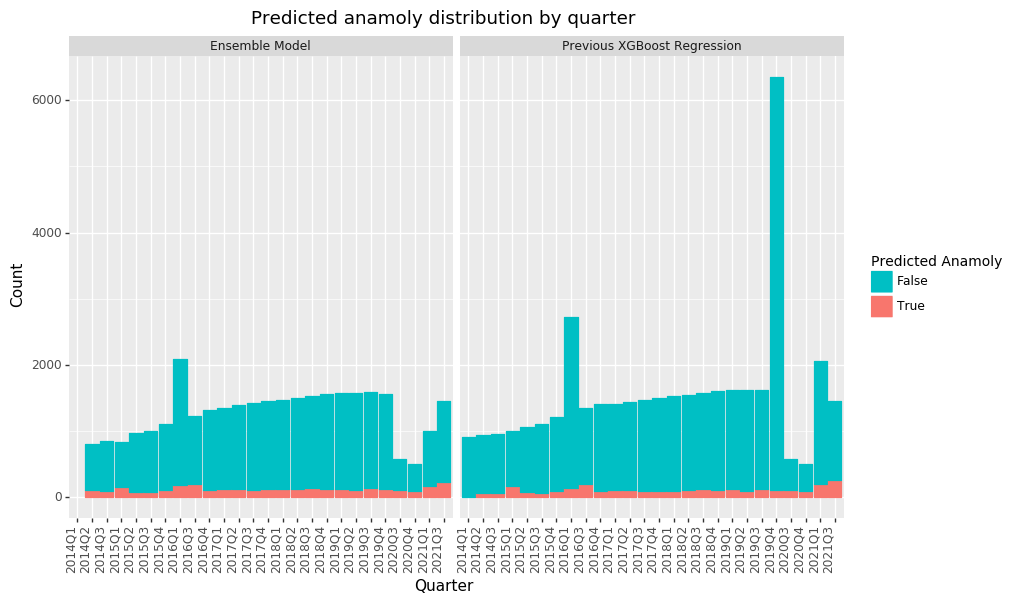

<ggplot: (8746893336145)>

In [108]:
plotnine.options.figure_size = (10,6)
(ggplot(versus_comparison_df,     
        aes(x = 'y_quarter',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Predicted anamoly distribution by quarter")
 + xlab("Quarter")
 + ylab("Count")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_bar()
 + theme(axis_text_x = element_text(rotation=90, hjust=1))
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
)